In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!nvidia-smi

Wed Apr 12 19:09:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |   1133MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/home/miladsoleymani/Human_Car_detection/notebooks
--2023-04-12 19:10:18--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 142.251.161.113, 142.251.161.100, 142.251.161.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.161.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t15ffbr7j62jttiedjc4d77vks012t4k/1681326600000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=5e96524c-500e-40eb-8b4a-9f3dda5f9923 [following]
--2023-04-12 19:10:19--  https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t15ffbr7j62jttiedjc4d77vks012t4k/1681326600000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=5e96524c-500e-40eb-8b4a-9f3dda5f9923
Resolving doc-0s-ag-docs.googleusercontent.com (doc

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.74 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (Tesla T4, 14960MiB)
Setup complete ✅ (4 CPUs, 14.6 GB RAM, 21.4/193.6 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q Cython
!pip install -q cython_bbox
!pip install -q onemetric
!pip install "numpy<1.24"

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
# settings
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|███████████████████████████████████████████████████████████████████| 131M/131M [00:00<00:00, 221MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 3 cars, 1 truck, 74.4ms
Speed: 0.7ms preprocess, 74.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


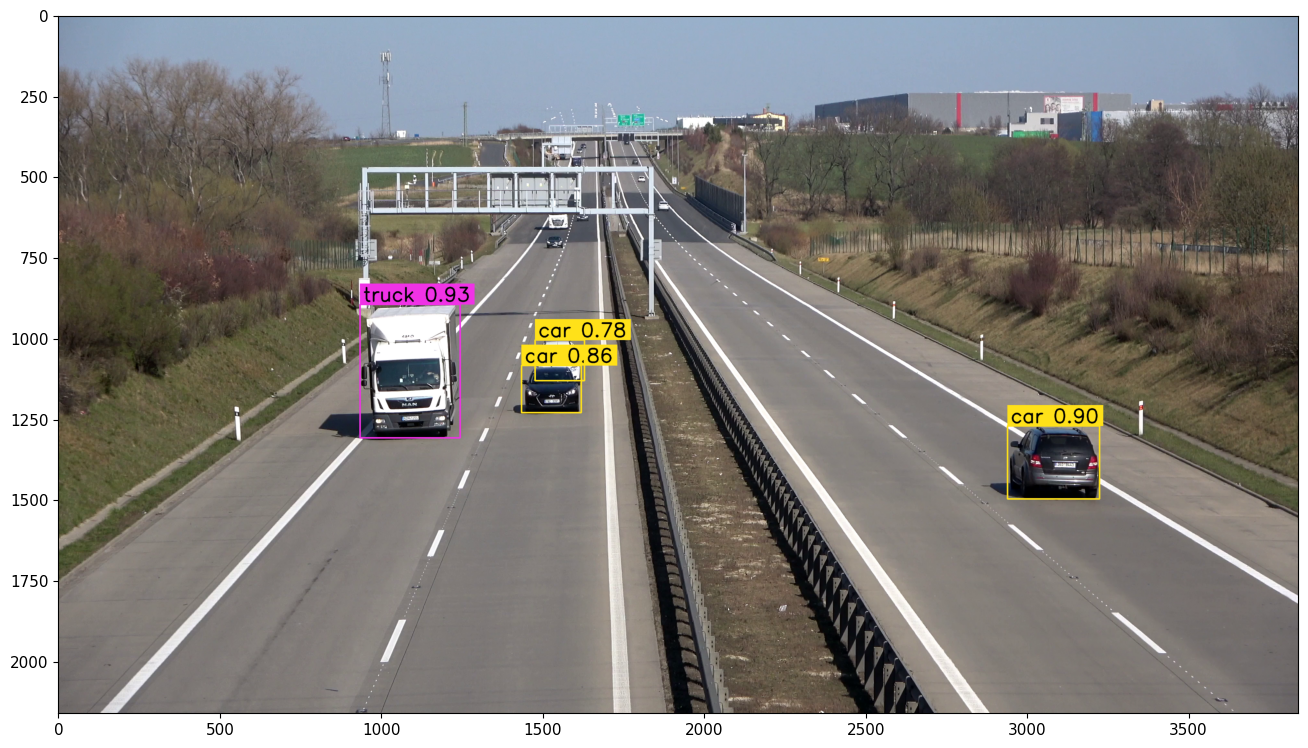

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/538 [00:00<?, ?it/s]


0: 384x640 3 cars, 1 truck, 63.5ms
Speed: 0.6ms preprocess, 63.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 cars, 1 truck, 63.5ms
Speed: 0.5ms preprocess, 63.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 63.5ms
Speed: 0.5ms preprocess, 63.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 1 truck, 63.5ms
Speed: 0.6ms preprocess, 63.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 63.5ms
Speed: 0.6ms preprocess, 63.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 63.7ms
Speed: 0.5ms preprocess, 63.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 63.5ms
Speed: 0.5ms preprocess, 63.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 1 truck, 63.7ms
Speed: 0.6ms preprocess, 63.7ms 


0: 384x640 1 person, 5 cars, 2 trucks, 45.0ms
Speed: 0.6ms preprocess, 45.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 2 trucks, 45.6ms
Speed: 0.6ms preprocess, 45.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 2 trucks, 46.4ms
Speed: 0.5ms preprocess, 46.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 46.8ms
Speed: 0.6ms preprocess, 46.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 43.5ms
Speed: 0.5ms preprocess, 43.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 42.7ms
Speed: 0.6ms preprocess, 42.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 42.7ms
Speed: 0.5ms preprocess, 42.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 40.6ms
Speed: 0.5ms pr


0: 384x640 4 cars, 1 truck, 39.9ms
Speed: 0.5ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.9ms
Speed: 0.5ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.9ms
Speed: 0.6ms preprocess, 39.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.9ms
Speed: 0.6ms preprocess, 39.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.9ms
Speed: 0.6ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 41.1ms
Speed: 0.5ms preprocess, 41.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 40.4ms
Speed: 0.5ms preprocess, 40.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 42.1ms
Speed: 0.5ms preprocess, 42.1ms i


0: 384x640 4 cars, 1 truck, 47.3ms
Speed: 0.5ms preprocess, 47.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 47.5ms
Speed: 0.5ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 44.8ms
Speed: 0.5ms preprocess, 44.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 44.9ms
Speed: 0.5ms preprocess, 44.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 44.9ms
Speed: 0.5ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 44.9ms
Speed: 0.5ms preprocess, 44.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 44.9ms
Speed: 0.5ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 44.9ms
Speed: 0.5ms preprocess, 44.9ms i


0: 384x640 4 cars, 1 truck, 39.4ms
Speed: 0.5ms preprocess, 39.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.4ms
Speed: 0.5ms preprocess, 39.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 4 cars, 2 trucks, 39.4ms
Speed: 0.5ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.5ms
Speed: 0.5ms preprocess, 39.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.4ms
Speed: 0.5ms preprocess, 39.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.4ms
Speed: 0.5ms preprocess, 39.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 39.5ms
Speed: 0.5ms preprocess, 39.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 42.6ms
Speed: 0.5ms preproces


0: 384x640 2 cars, 1 truck, 39.5ms
Speed: 0.6ms preprocess, 39.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 cars, 1 truck, 39.4ms
Speed: 0.5ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 car, 1 truck, 39.5ms
Speed: 0.6ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 cars, 1 truck, 39.5ms
Speed: 0.5ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 cars, 1 truck, 39.5ms
Speed: 0.5ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 cars, 1 truck, 39.5ms
Speed: 0.5ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 cars, 1 truck, 39.5ms
Speed: 0.5ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 cars, 1 truck, 39.5ms
Speed: 0.7ms preprocess, 39.5ms in